<a href="https://colab.research.google.com/github/RuleOfNight/Pytorch_Deep_Learning-study-/blob/main/05_PyTorch_Modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.makedirs("going_modular", exist_ok=True)
import torch
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
%%writefile going_modular/get_data.py
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

if image_path.is_dir():
    print(f"Đã có file {image_path}")
else:
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Đang tải dữ liệu...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Đang giải nén...")
        zip_ref.extractall(image_path)
        print("Done, chào mừng tới hell kitchen")

Overwriting going_modular/get_data.py


In [ ]:
!python going_modular/get_data.py

Đã có file data/pizza_steak_sushi


In [ ]:
from torchvision import datasets, transforms
from going_modular import get_data as gtd

train_dir = gtd.train_dir
test_dir = gtd.test_dir

train_dir, test_dir

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Đã có file data/pizza_steak_sushi
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e20c7af8510>,
 <torch.utils.data.dataloader.DataLoader at 0x7e20c8ac79d0>)

In [ ]:
img, label = next(iter(train_dataloader))


print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  # DataLoaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


In [ ]:
%%writefile going_modular/model_builder.py
import torch

from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.block_2(self.block_1(x)))

Writing going_modular/model_builder.py


In [ ]:
import torch

from going_modular import model_builder

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
torch.manual_seed(42)
model_1 = model_builder.TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                                hidden_units=10,
                                output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
%%writefile going_modular/engine.py

from typing import Dict, List, Tuple

import torch

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:


    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)


    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:


    model.eval()
    test_loss, test_acc = 0, 0

    # inference
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)


            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:


    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }


    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)


        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


    return results

Writing going_modular/engine.py


In [ ]:
%%writefile going_modular/save.py

from pathlib import Path

import torch

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    # target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing going_modular/save.py


In [ ]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import argparse

import torch
from torchvision import transforms

import data_setup, engine, model_builder, save

def parse_args():
    parser = argparse.ArgumentParser(description="Train a PyTorch image classification model.")

    parser.add_argument("--num_epochs", type=int, default=5)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--hidden_units", type=int, default=10)
    parser.add_argument("--learning_rate", type=float, default=0.001)
    parser.add_argument("--train_dir", type=str, default="data/pizza_steak_sushi/train")
    parser.add_argument("--test_dir", type=str, default="data/pizza_steak_sushi/test")
    parser.add_argument("--model_save_name", type=str, default="05_going_modular_script_mode_tinyvgg_model.pth")

    return parser.parse_args()

def main():
    # Parse command line arguments
    args = parse_args()


    NUM_EPOCHS = args.num_epochs
    BATCH_SIZE = args.batch_size
    HIDDEN_UNITS = args.hidden_units
    LEARNING_RATE = args.learning_rate
    train_dir = args.train_dir
    test_dir = args.test_dir
    model_save_name = args.model_save_name


    device = "cuda" if torch.cuda.is_available() else "cpu"


    data_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    # data_setup.py
    train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
        train_dir=train_dir,
        test_dir=test_dir,
        transform=data_transform,
        batch_size=BATCH_SIZE
    )

    # model_builder.py
    model = model_builder.TinyVGG(
        input_shape=3,
        hidden_units=HIDDEN_UNITS,
        output_shape=len(class_names)
    ).to(device)

    # loss and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=LEARNING_RATE)

    # engine.py
    engine.train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=NUM_EPOCHS,
                device=device)

    # save.py
    save.save_model(model=model,
                    target_dir="models",
                    model_name=model_save_name)

if __name__ == "__main__":
    main()

Writing going_modular/train.py


In [ ]:
!python going_modular/train.py

  0% 0/5 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.1128 | train_acc: 0.2461 | test_loss: 1.0949 | test_acc: 0.2604
 20% 1/5 [00:01<00:07,  1.81s/it]Epoch: 2 | train_loss: 1.0895 | train_acc: 0.4219 | test_loss: 1.1294 | test_acc: 0.1979
 40% 2/5 [00:03<00:05,  1.82s/it]Epoch: 3 | train_loss: 1.1061 | train_acc: 0.2930 | test_loss: 1.1562 | test_acc: 0.1979
 60% 3/5 [00:05<00:03,  1.82s/it]Epoch: 4 | train_loss: 1.1194 | train_acc: 0.2930 | test_loss: 1.1375 | test_acc: 0.2083
 80% 4/5 [00:07<00:01,  1.80s/it]Epoch: 5 | train_loss: 1.0992 | train_acc: 0.3281 | test_loss: 1.0623 | test_acc: 0.5634
100% 5/5 [00:09<00:00,  1.81s/it]
[INFO] Saving model to: models/05_going_modular_script_mode_tinyvgg_model.pth


In [ ]:
!python going_modular/train.py \
    --num_epochs 10 \
    --batch_size 64 \
    --hidden_units 20 \
    --learning_rate 0.0001 \
    --model_save_name "custom_tinyvgg_model.pth"

  0% 0/10 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.0988 | train_acc: 0.3097 | test_loss: 1.0968 | test_acc: 0.2550
 10% 1/10 [00:03<00:27,  3.00s/it]Epoch: 2 | train_loss: 1.0975 | train_acc: 0.3372 | test_loss: 1.0991 | test_acc: 0.2251
 20% 2/10 [00:05<00:22,  2.86s/it]Epoch: 3 | train_loss: 1.0955 | train_acc: 0.4411 | test_loss: 1.0981 | test_acc: 0.3864
 30% 3/10 [00:09<00:22,  3.21s/it]Epoch: 4 | train_loss: 1.0940 | train_acc: 0.4735 | test_loss: 1.1013 | test_acc: 0.2344
 40% 4/10 [00:12<00:18,  3.01s/it]Epoch: 5 | train_loss: 1.0903 | train_acc: 0.4257 | test_loss: 1.1002 | test_acc: 0.2188
 50% 5/10 [00:14<00:14,  2.94s/it]Epoch: 6 | train_loss: 1.0885 | train_acc: 0.3912 | test_loss: 1.1026 | test_acc: 0.2031
 60% 6/10 [00:17<00:11,  2.86s/it]Epoch: 7 | train_loss: 1.0875 | train_acc: 0.3648 | test_loss: 1.1071 | test_acc: 0.2031
 70% 7/10 [00:20<00:08,  2.88s/it]Epoch: 8 | train_loss: 1.0835 | train_acc: 0.3761 | test_loss: 1.1086 | test_acc: 0.2031
 80% 8/10 [00:24<00:06, 

In [ ]:
%%writefile going_modular/predict.py
"""
Visualizes model predictions - Colab compatible version
"""

import argparse
import matplotlib.pyplot as plt
import torch
import random
from pathlib import Path
from typing import List
from torchvision import transforms
from PIL import Image

# Import existing modules
from model_builder import TinyVGG
from train import parse_args

def show_predictions(
    model: torch.nn.Module,
    test_dir: str,
    class_names: List[str],
    device: torch.device,
    num_images: int = 5,
    seed: int = 42
):
    """Shows model predictions on random test images."""
    random.seed(seed)
    test_image_paths = list(Path(test_dir).glob("*/*.jpg"))
    selected_images = random.sample(test_image_paths, k=num_images)

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    fig = plt.figure(figsize=(15, 10))

    for i, image_path in enumerate(selected_images):
        img = Image.open(image_path)
        img_tensor = transform(img).unsqueeze(0).to(device)
        true_label = image_path.parent.stem

        model.eval()
        with torch.inference_mode():
            pred_logits = model(img_tensor)
            pred_prob = torch.softmax(pred_logits, dim=1)
            pred_label = class_names[pred_prob.argmax()]
            confidence = pred_prob.max().item()

        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
        ax.axis('off')

    plt.tight_layout()
    return fig  # Trả về figure thay vì show trực tiếp

def main():
    args = parse_args()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    class_names = sorted([item.name for item in Path(args.test_dir).glob("*")])

    model = TinyVGG(
        input_shape=3,
        hidden_units=args.hidden_units,
        output_shape=len(class_names)
    ).to(device)

    model.load_state_dict(torch.load(f"models/{args.model_save_name}"))

    fig = show_predictions(
        model=model,
        test_dir=args.test_dir,
        class_names=class_names,
        device=device
    )

    # Lưu ảnh vào file
    fig.savefig("predictions.png")
    print("Predictions saved to predictions.png")

if __name__ == "__main__":
    main()

Overwriting going_modular/predict.py


In [ ]:
!python going_modular/predict.py \
    --test_dir "data/pizza_steak_sushi/test" \
    --model_save_name "05_going_modular_script_mode_tinyvgg_model.pth"

Predictions saved to predictions.png


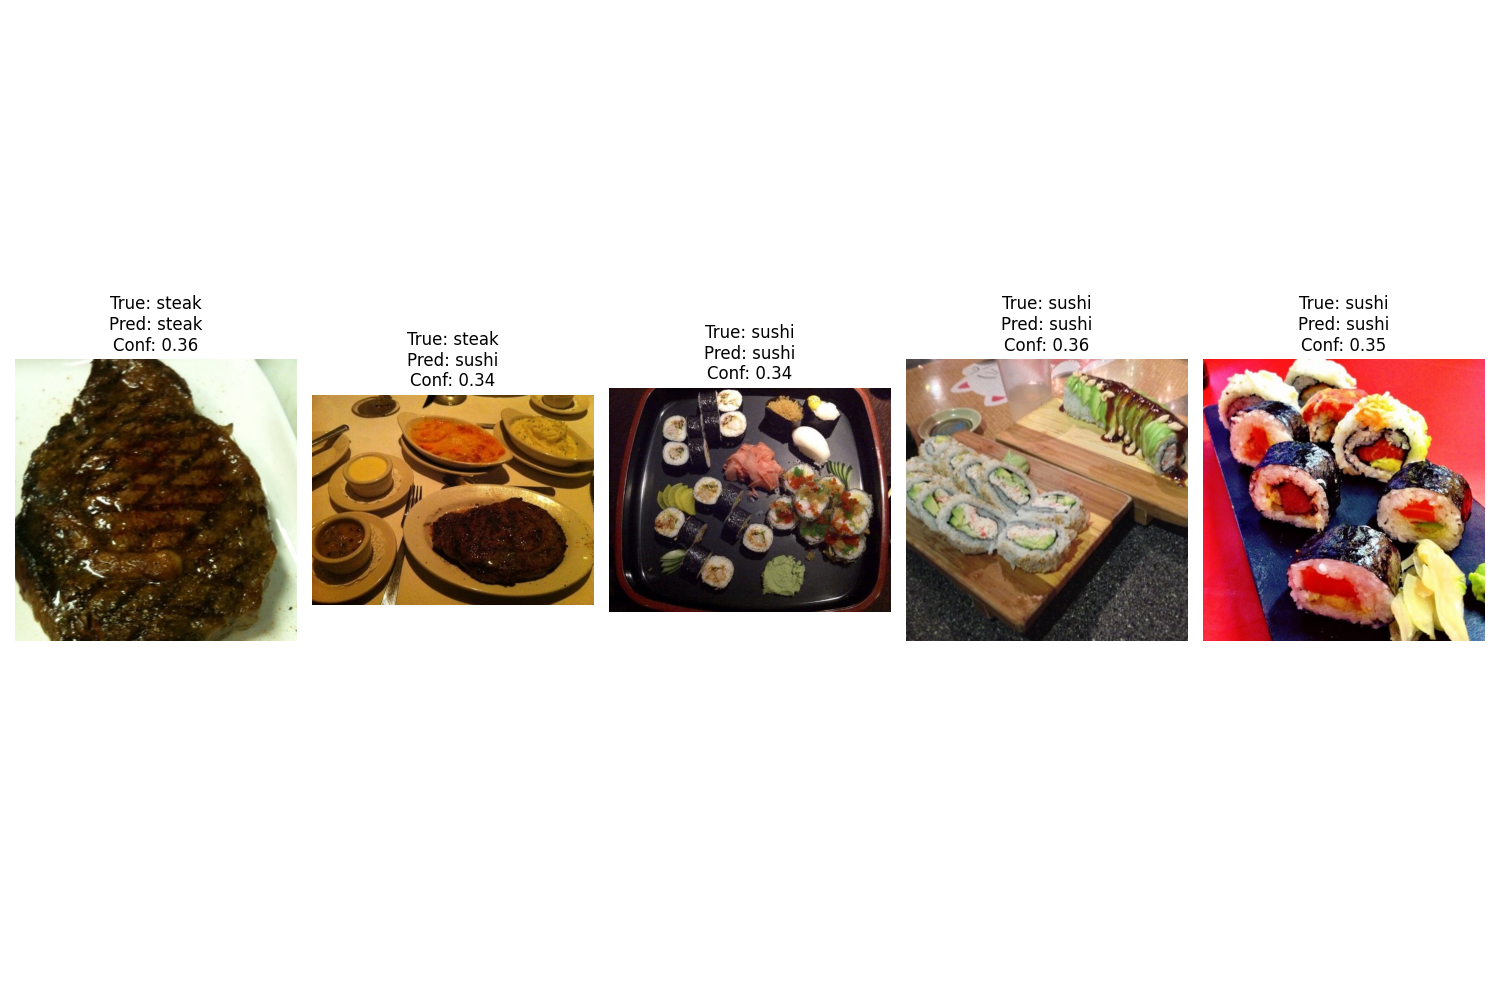

In [ ]:
from IPython.display import Image
Image(filename="predictions.png")  # Hiển thị ảnh đã lưu

In [ ]:
%%writefile going_modular/utils.py
from IPython.display import Image
def show_in_colab(fig):
    """Hiển thị matplotlib figure trong Colab"""
    from IPython.display import display
    import io
    import base64

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    display(Image(base64.b64encode(buf.getvalue()).decode('utf-8')))

Overwriting going_modular/utils.py
